In [24]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [40]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats

def multi_plot(yss, preds, ud = 'up'):
    ticks=[[7,8,9,10], [-4,-3,-2,-1,0], [-8,-6,-4,-2,0], [-8,-6,-4,-2,0], [5,6,7,8,9]]
    if ud=='up':
        j=0
        N=2
        a, b = 22, 8.5
    else:
        j=2
        N=5
        a, b = 22, 5.5
    fig, ax = plt.subplots(1, N-j, figsize=(a, b))
    ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets=[ r"log($M_{cold}/M_{\odot}$)", r"log($SFR/M_{\odot}/yr$)"]
    targets=[ r"log($M_{cold}/M_{\odot}$)", r"$log(Z_{gas})$", r"log($SFR/M_{\odot}/yr$)",
            r"log($SFR_{100}/M_{\odot}/yr$)", r"log($M_{BH}/M_{\odot}$)"]
    targets=[ r"$M_{cold}$", r"$Z_{gas}$", r"$SFR$",
            r"$SFR_{100}$", r"$M_{BH}$"]
    # target=r"$v_{disk}$"
    for i in range(j, N):
        target=targets[i]
        tick = ticks[i]
        ys = yss[:,i]
        pred = preds[:,i]
        nullfmt = NullFormatter()         # no labels
        # definitions for the axes
        left, width = 0.15, 0.67
        bottom, height = 0.0, 0.75
        bottom_h = bottom +height
        left_h = left + width
        # rect_Cbar = [0, bottom, 0.1, height]
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.15]
        rect_histy = [left_h, bottom, 0.15+0.05, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

        # start with a rectangular Figure
        ax[i-j].set_axis_off()
        # axCbar = plt.axes(rect_Cbar)
        axHist = ax[i-j].inset_axes(rect_scatter)
        axHistx = ax[i-j].inset_axes(rect_histx)
        axHisty = ax[i-j].inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)

        bins=50
        l=0.0
        n_contour=4
        # the scatter plot:
        vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                    np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
        axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
        axHist.set(xlabel=f'SAM {target}',ylabel=f'GNN {target}')
        axHist.xaxis.label.set_fontsize(24-j*2)
        axHist.yaxis.label.set_fontsize(24-j*2)
        
        if i==0:
            axHist.legend(fontsize=15, loc='upper left')

        X, Y = X[0], Y.T[0]
        axHist.set_xlim((min(X), max(X)))
        axHist.set_ylim((min(Y), max(Y)))
        yhat=r'$\hat{y}$'

        #calculate metrics
        pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
        r2=r2_score(ys,pred)
        rho = np.corrcoef(ys,pred)[0,1]
        print('bias', np.mean(ys-pred))
        print('std', np.std(ys-pred))
        print('rho', rho)
        print('r2', r2)
        print('pct',pct)
        
        xt=0.45
        yt=0.2
        dy=0.07
        font = {'weight': 'normal',
            'size': 20 - j*2}
        if i==4:
            xt=0.1
            yt=0.9
        axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


        # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
        # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
        ys_kde = stats.gaussian_kde(ys, 0.1)
        pred_kde = stats.gaussian_kde(pred, 0.1)
        axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
        axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
        axHistx.legend(fontsize=15)
        axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.15), fontsize=15)

        font = {'family' : 'Serif',
                'weight' : 'normal',
                'size'   : 20-j}

        matplotlib.rc('font', **font)

        axHistx.set(title=f'SAM-GNN {target}', )

        axHistx.set_xlim(axHist.get_xlim())
        axHisty.set_ylim(axHist.get_ylim())
        
        axHist.set(xticks=tick, yticks=tick)

        divider = make_axes_locatable(axHisty)
        cax = divider.append_axes("right", size="15%", pad=0.18)
        divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

        # Plot vertical colorbar
        plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

In [41]:
# this is the full tree run
# folder = 'results_final_Z_270322'
# run = 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_msdgfh_1_2'

folder = 'results_final_Z_300322'
run = 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_mllteo'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
ys, pred = results['low_ys'], results['low_pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2]+9, pred[:,2]+9
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

In [42]:
Zy-=Coldy
Zpred-=Coldpred
ys = np.vstack([Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([ Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

bias -0.009020476
std 0.16122602
rho 0.9539267965122156
r2 0.9096284409510441
pct 0.8347709765210573
bias -0.0051141777
std 0.12319682
rho 0.9735407519267769
r2 0.9476915282405681
pct 0.963005673693436


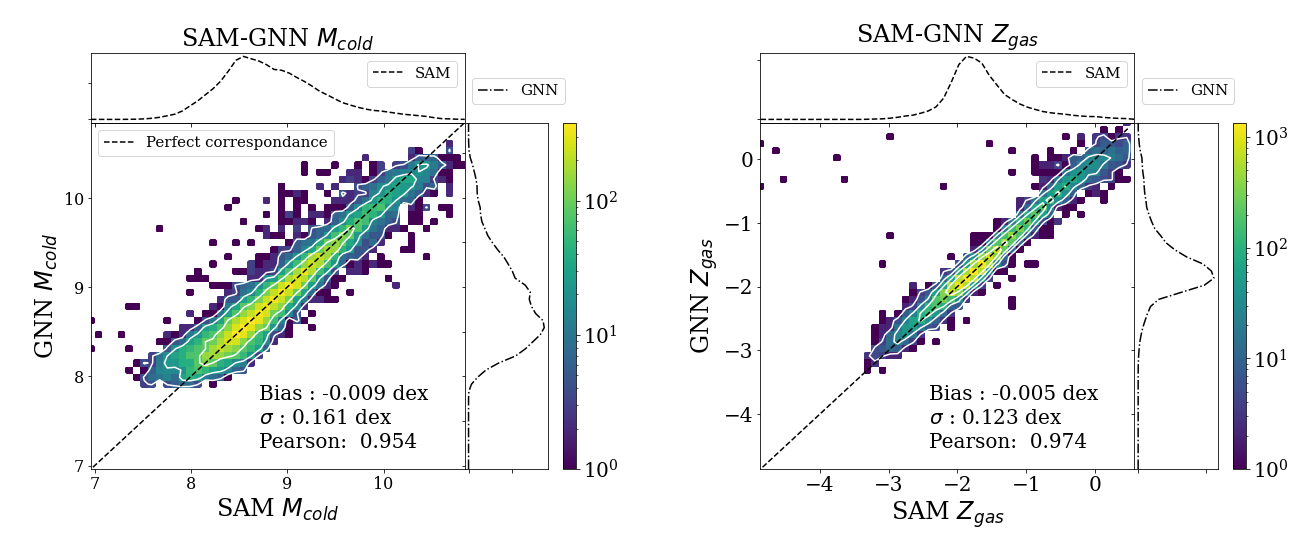

In [46]:
import matplotlib
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
fig=multi_plot(ys, pred, ud='up')
fig.savefig('../paper_figures/primary_others_final.png', )

bias 0.025161581
std 0.3533209
rho 0.9358653220313943
r2 0.8751873435045804
pct 0.5662161538816366
bias 0.022227764
std 0.346989
rho 0.9379980769953581
r2 0.8792673518882322
pct 0.5644633055030214
bias -0.0014875496
std 0.1272272
rho 0.9746096083734238
r2 0.9498136646193903
pct 0.9092209050232944


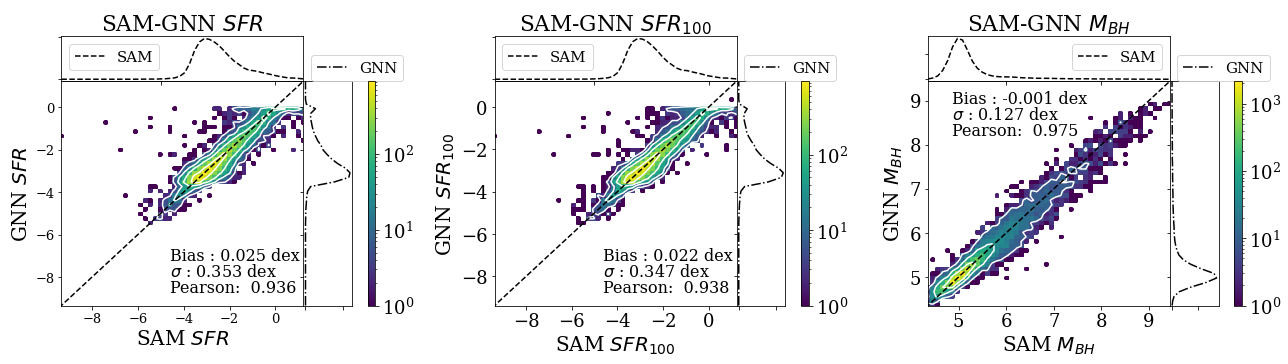

In [47]:
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 13}
matplotlib.rc('font', **font)
fig=multi_plot(ys, pred, ud='down')
fig.savefig('../paper_figures/secondary_others_final.png', )

In [ ]:
nullfmt = NullFormatter() 
for i in range(len(axd)):
    axd[i].xaxis.set_major_formatter(nullfmt)
    axd[i].yaxis.set_major_formatter(nullfmt)    

In [ ]:
fig.tight_layout()

In [39]:
xticks=[[7,8,9,10], [-4,-3,-2,-1,0], [-8,-6,-4,-2,0], [-8,-6,-4,-2,0], [5,6,7,8,9]]